In [2]:
import lasio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
las_path = "Ichthys-2AST2_S3R1_OBMI-AIT-LDT-LDS-APS-HNGS_MainRaw_LUC.las"
las_data = lasio.read(las_path)

for idx, curve in enumerate(las_data.curves):
    print(f"Curve: {curve.mnemonic}, Units: {curve.unit}, Description: {curve.descr}")
print(f"Total number of curves: {idx + 1}")

well_log = las_data.df()
print(well_log.head())
print(well_log.info())

Only engine='normal' can read wrapped files


Curve: DEPTH, Units: M, Description: 1  Depth
Curve: BS, Units: in, Description: 2  Bit Size
Curve: CS, Units: ft/h, Description: 3  Cable Speed
Curve: TENS, Units: lbf, Description: 4  Cable Tension
Curve: ETIM, Units: s, Description: 5  Elapsed Logging Time
Curve: DCAL, Units: in, Description: 6  Differential Caliper
Curve: FCD, Units: in, Description: 7  Future Casing Diameter
Curve: HDAR, Units: in, Description: 8  Hole Diameter from Area
Curve: P1NO_OBMT, Units: deg, Description: 9  Memorized Pad 1 rotation rel. NORTH
Curve: DEVI, Units: deg, Description: 10  Hole Deviation
Curve: RB_OBMT, Units: deg, Description: 11  Memorized Relative Bearing
Curve: P1AZ_OBMT, Units: deg, Description: 12  Memorized Pad 1 Azimuth
Curve: ANOR, Units: m/s2, Description: 13  Acceleration Computed Norm
Curve: HAZI, Units: deg, Description: 14  Hole Azimuth
Curve: P1AZ, Units: deg, Description: 15  Pad 1 Azimuth
Curve: RB, Units: deg, Description: 16  Relative Bearing
Curve: SDEV, Units: deg, Descript

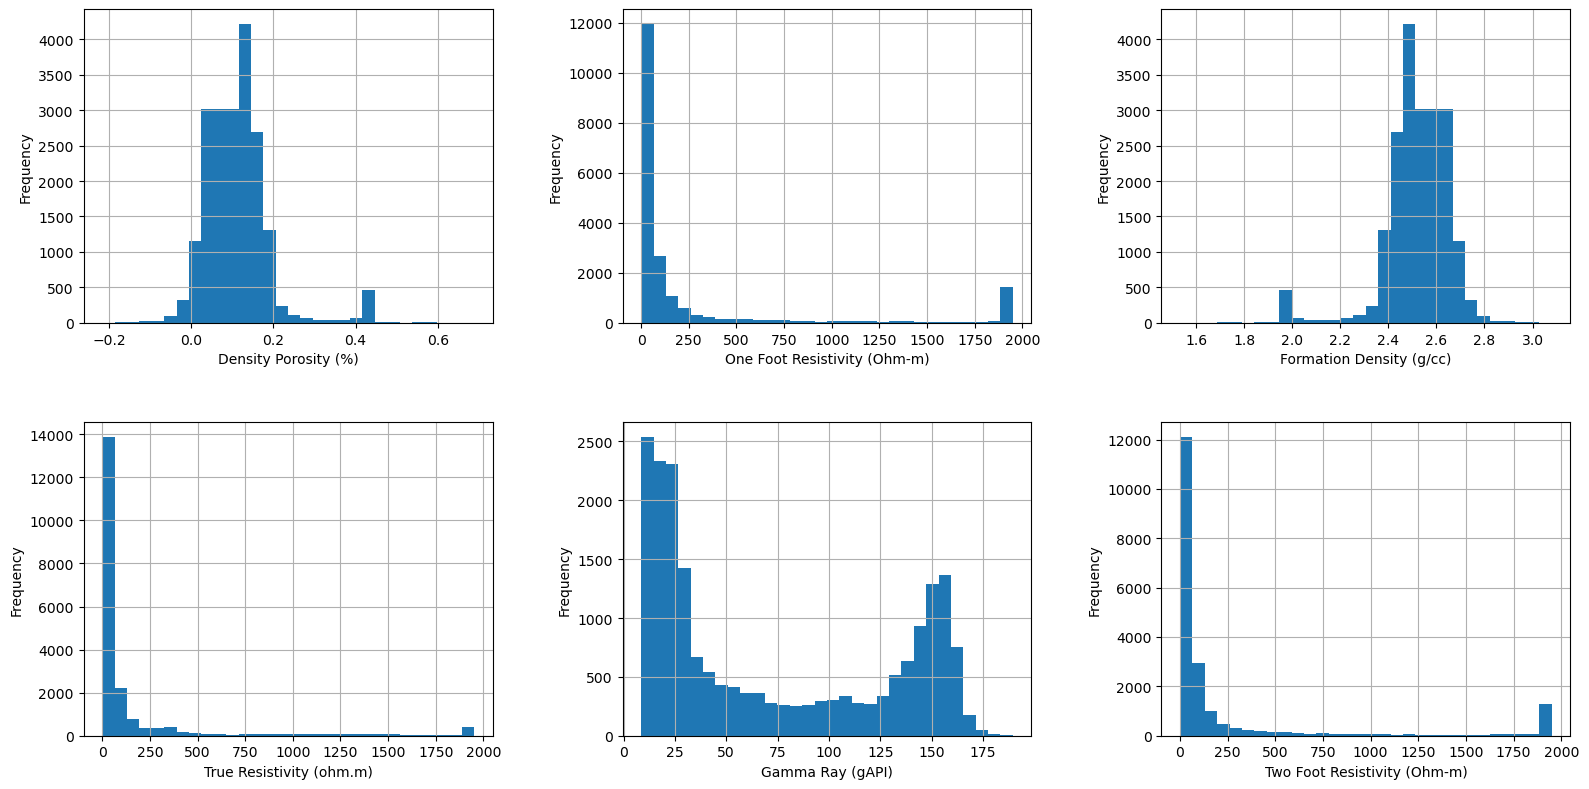

In [4]:
plt.figure(figsize=(16, 8))
log_columns = [
    ('DPHI', 'Density Porosity (%)',),
    ('AO10', 'One Foot Resistivity (Ohm-m)'),
    ('RHOB', 'Formation Density (g/cc)'),
    ('RT', 'True Resistivity (ohm.m)'),
    ('HSGR', 'Gamma Ray (gAPI)'),
    ('AT10', 'Two Foot Resistivity (Ohm-m)')
]

for i, (col, xlabel) in enumerate(log_columns, 1):
    plt.subplot(2, 3, i)
    well_log[col].plot.hist(bins=30)
    plt.xlabel(xlabel)
    plt.ylabel("Frequency")
    plt.grid(True)

plt.tight_layout(h_pad=4, w_pad=4)
plt.show()


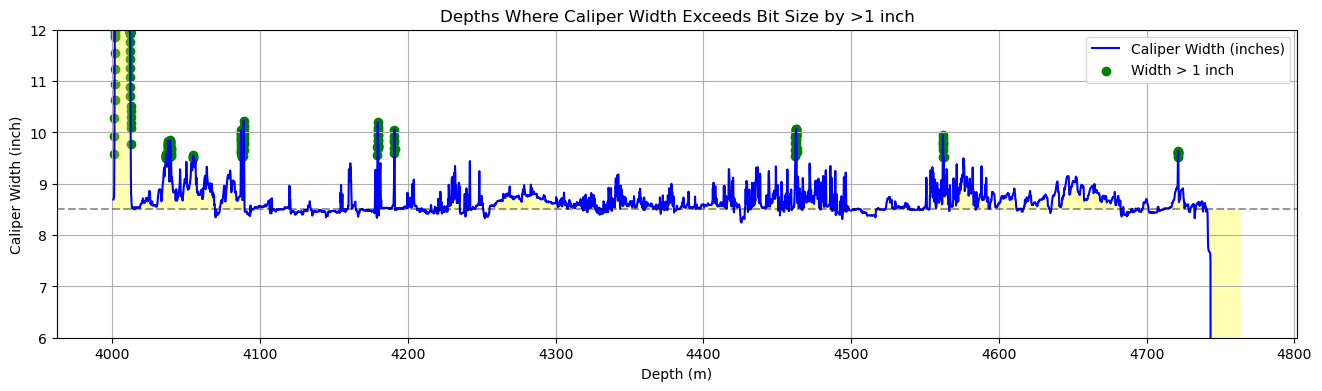

In [5]:
plt.figure(figsize=(16, 4))
bit_diameter = 8.5
exceed_idx = (well_log['CALI'] - bit_diameter) > 1

plt.plot(well_log.index, well_log['CALI'], color='blue', label='Caliper Width (inches)')
plt.axhline(y=bit_diameter, color='black', linestyle='--', alpha=0.4)
plt.scatter(well_log.index[exceed_idx], well_log['CALI'][exceed_idx], color='green', label='Width > 1 inch')
plt.fill_between(well_log.index, bit_diameter, well_log["CALI"], facecolor='yellow', alpha=0.3)
plt.ylim(6, 12)
plt.xlabel("Depth (m)")
plt.ylabel("Caliper Width (inch)")
plt.grid(True)
plt.legend()
plt.title("Depths Where Caliper Width Exceeds Bit Size by >1 inch")
plt.show()

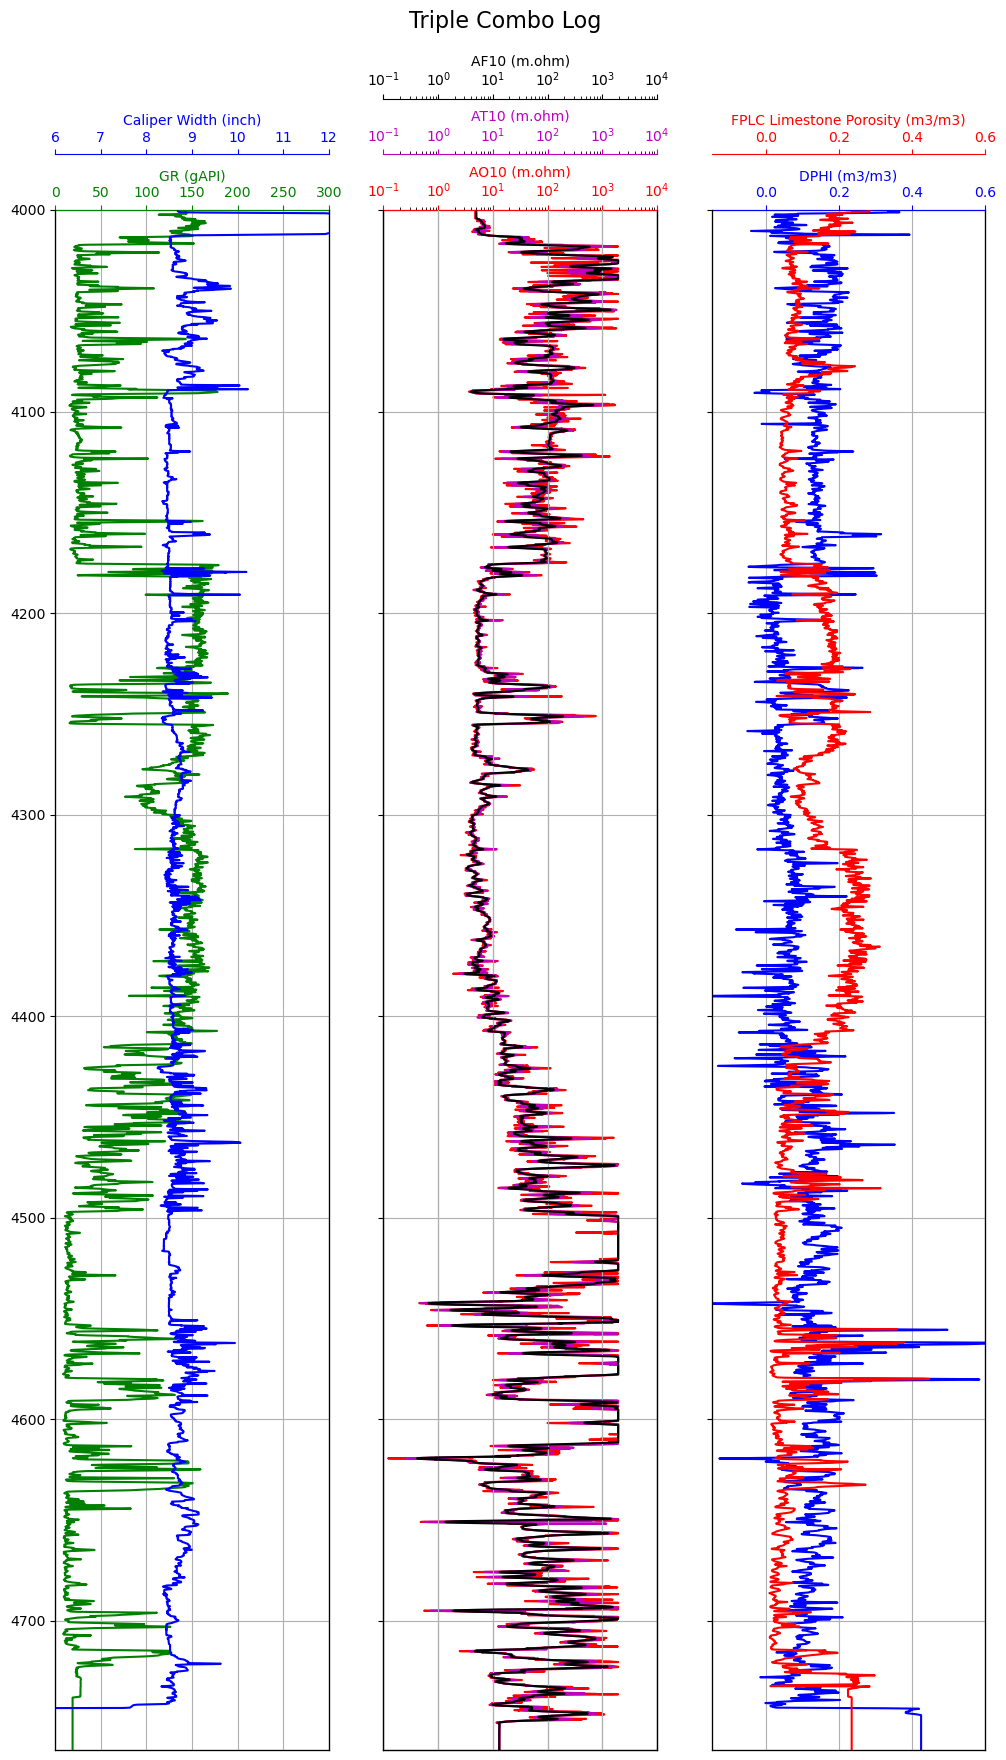

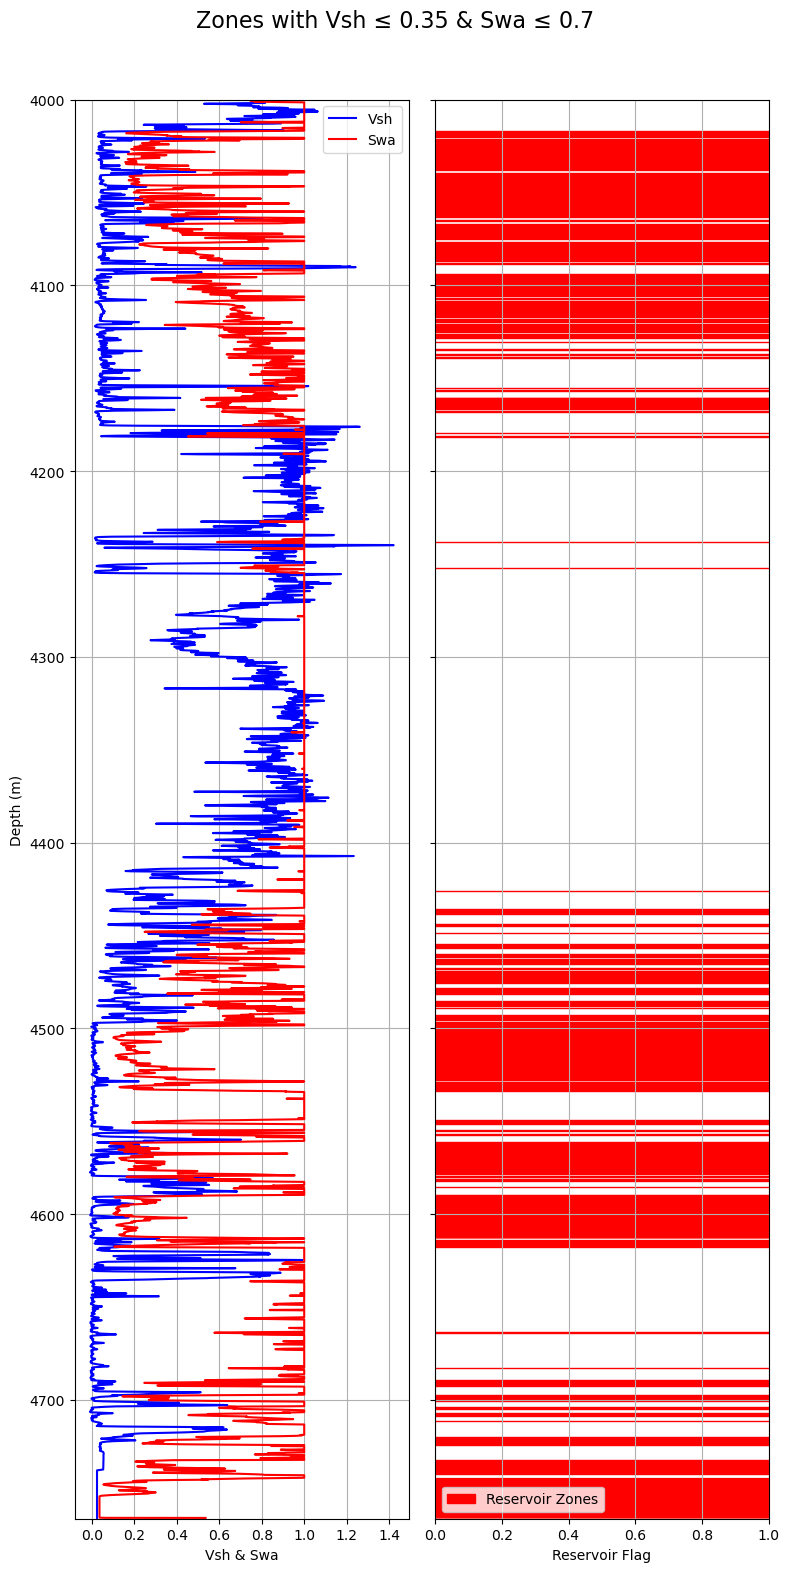

In [6]:
def plot_triple_combo(log_df, top=4000, bottom=4764):
    section = log_df.loc[top:bottom]
    fig, axes = plt.subplots(1, 3, figsize=(12, 20), sharey=True)
    fig.suptitle("Triple Combo Log", fontsize=16)

    for ax in axes:
        ax.set_ylim(top, bottom)
        ax.invert_yaxis()
        ax.yaxis.grid(True)
        ax.get_xaxis().set_visible(False)

    # Track 1: GR and CALI
    ax1 = axes[0].twiny()
    ax1.plot(section['HSGR'], section.index, '-g', label='GR (gAPI)')
    ax1.set_xlabel("GR (gAPI)", color='g')
    ax1.tick_params(axis='x', colors='g')
    ax1.spines['top'].set_color('g')
    ax1.set_xlim(0, 300)
    ax1.grid(True)

    ax1b = axes[0].twiny()
    ax1b.plot(section['CALI'], section.index, '-b', label='CALI')
    ax1b.set_xlabel("Caliper Width (inch)", color='b')
    ax1b.spines['top'].set_position(('outward', 40))
    ax1b.spines['top'].set_color('b')
    ax1b.set_xlim(6, 12)
    ax1b.tick_params(axis='x', colors='b')

    # Track 2: Resistivity
    for col, color, label, offset in zip(['AO10', 'AT10', 'AF10'], ['r', 'm', 'k'], ['AO10', 'AT10', 'AF10'], [0, 40, 80]):
        ax2 = axes[1].twiny()
        ax2.set_xscale("log")
        ax2.plot(section[col], section.index, f'-{color}', label=label)
        ax2.set_xlabel(f"{label} (m.ohm)", color=color)
        ax2.spines['top'].set_position(('outward', offset))
        ax2.spines['top'].set_color(color)
        ax2.tick_params(axis='x', colors=color)
        ax2.set_xlim(0.1, 10000)
        ax2.grid(True)

    # Track 3: Porosity
    ax3 = axes[2].twiny()
    ax3.plot(section['DPHI'], section.index, '-b', label='DPHI')
    ax3.set_xlabel("DPHI (m3/m3)", color='b')
    ax3.tick_params(axis='x', colors='b')
    ax3.set_xlim(-0.15, 0.60)
    ax3.spines['top'].set_color('b')
    ax3.grid(True)

    ax4 = axes[2].twiny()
    ax4.plot(section['FPLC'], section.index, '-r', label='FPLC')
    ax4.set_xlabel("FPLC Limestone Porosity (m3/m3)", color='r')
    ax4.tick_params(axis='x', colors='r')
    ax4.spines['top'].set_color('r')
    ax4.set_xlim(-0.15, 0.60)
    ax4.spines['top'].set_position(('outward', 40))

    plt.show()

plot_triple_combo(well_log)

water_wet = well_log[
    (well_log['HSGR'] <= 50) &
    (abs(well_log['AO10'] - well_log['AT10']) <= 1) &
    (well_log.index >= 4020) &
    (well_log.index <= 4180)
].copy()

zone = water_wet[['HSGR', 'FPLC', 'AO10', 'AT10', 'AORX', 'DPHI']].dropna()
zone['abs_diff'] = abs(zone['AO10'] - zone['AT10'])
zone_sorted = zone.sort_values(by='abs_diff')

selected_rows, selected_depths = [], []
for depth, row in zone_sorted.iterrows():
    if all(abs(depth - d) >= 10 for d in selected_depths):
        selected_rows.append(row)
        selected_depths.append(depth)
    if len(selected_rows) == 25:
        break

top_points = pd.DataFrame(selected_rows)
top_points.index = selected_depths
top_points.index.name = 'DEPTH'

depths_to_remove = [4082.4912, 4071.6327, 4168.7877, 4099.9791, 4056.5451]
top_points = top_points.drop(index=depths_to_remove, errors='ignore')

rw = 0.265
a = 1
well_log['Total_porosity'] = (well_log['FPLC'] + well_log['DPHI']) / 2
well_log['Swa'] = ((a * rw) / (well_log['RT'] * well_log['Total_porosity'] ** 2)) ** 0.5
well_log['Swa_c'] = well_log['Swa'].clip(upper=1)

gr = well_log['HSGR']
p5 = np.percentile(gr, 5)
p95 = np.percentile(gr, 95)
I_gr = (gr - p5) / (p95 - p5)
well_log['Vsh'] = 0.33 * (2 ** (2 * I_gr) - 1)

flag_condition = (well_log['Vsh'] <= 0.35) & (well_log['Swa_c'] <= 0.7)
fig, axes = plt.subplots(1, 2, figsize=(8, 16), sharey=True)
fig.suptitle("Zones with Vsh ≤ 0.35 & Swa ≤ 0.7", fontsize=16)

axes[0].plot(well_log['Vsh'], well_log.index, color='blue', label='Vsh')
axes[0].plot(well_log['Swa_c'], well_log.index, color='red', label='Swa')
axes[0].set_ylim(4764, 4000)
axes[0].set_ylabel("Depth (m)")
axes[0].set_xlabel("Vsh & Swa")
axes[0].grid(True)
axes[0].legend()

axes[1].fill_betweenx(well_log.index, 0, 1, where=flag_condition, color='red', label='Reservoir Zones')
axes[1].set_ylim(4764, 4000)
axes[1].set_xlim(0, 1)
axes[1].set_xlabel("Reservoir Flag")
axes[1].grid(True)
axes[1].legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
